### Visualize Effect of Uncertainty in a Decline Curve



Given a range of decline paramters [Qi, De, b_factor], visualize Decline of a well.



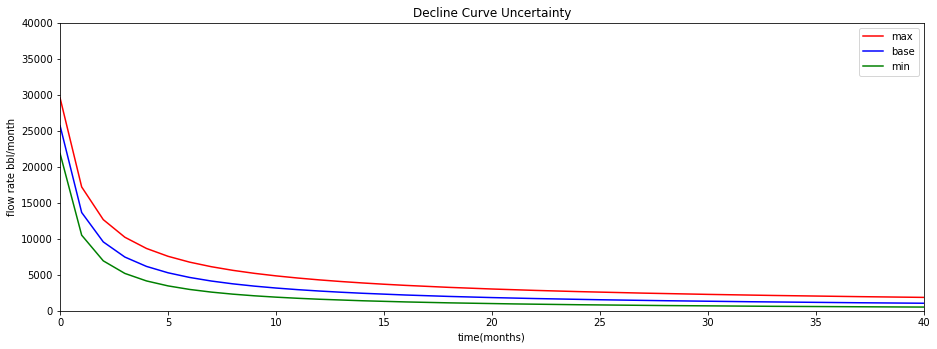

In [2]:
import numpy as np
import statistics as s
import math as m
import matplotlib.pyplot as plt


t = np.arange(0,360) #30 years in terms of months
units = 'bbl'

Qi_day = 845.56
Qi = Qi_day*30.4 #bbl/month
Qmin = .85*Qi
Qmax = 1.15*Qi
Qi_range = np.linspace(Qmin,Qmax,len(t))

De = .9472
Demax = 0.85*De #lower decline is max
Demin = 1.15*De #higher decline is min
De_range = np.linspace(Demin,Demax, len(t))

b = 1.2
bmin = .85*b
bmax = 1.15*b
b_range = np.linspace(bmin,bmax, len(t))

ratesmin = []
rates = []
ratesmax = []
for i in range(0,len(t)):
    ymin = Qmin/(1 + bmin*Demin*t[i])**(1/bmin) 
    y = Qi/(1 + b*De*t[i])**(1/b) 
    ymax = Qmax/(1 + bmax*Demax*t[i])**(1/bmax) 
    
    rates = np.append(rates,y)
    ratesmin = np.append(ratesmin,ymin)
    ratesmax = np.append(ratesmax,ymax)
    
plt.subplot(1,1,1)
plt.plot(t,ratesmax,'red',label = 'max')
plt.plot(t,rates,'blue', label = 'base')
plt.plot(t,ratesmin,'green',label = 'min')
plt.xlabel('time(months)')
plt.ylabel('flow rate '+ units +'/month')
plt.title('Decline Curve Uncertainty')
plt.legend()
plt.xlim(0,40)
plt.ylim(0,40000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

### Measuring Uncertainty in the Estimated Ultimate Recovery of Single well.



Given a range of decline paramters [Qi, De, b_factor], calculate Cummulative Production for a given amount of time.
Use bootstrap to measure uncertainty in the mean of Cummulative Production.

10% chance of having 257097.9666884692 or more  bbl 
50% chance of having 237941.87183956502 or more  bbl 
90% chance of having 220916.55028817046 or more  bbl 


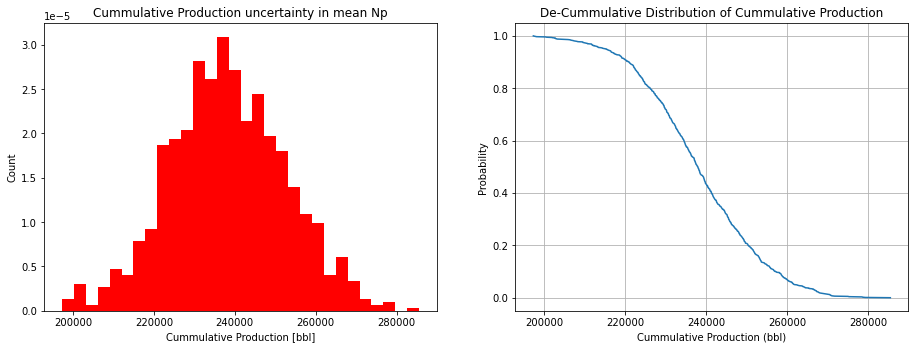

In [3]:
import numpy as np
import statistics as s
import math as m
import matplotlib.pyplot as plt



t = np.arange(0,360) #30 years in terms of months
units = 'bbl'

Qi_day = 845.56
Qi = Qi_day*30.4 #bbl/month
Qmin = .25*Qi
Qmax = 1.25*Qi
Qi_range = np.linspace(Qmin,Qmax,len(t))

De = .9472
Demax = 0.25*De #lower decline is max
Demin = 1.25*De #higher decline is min
De_range = np.linspace(Demin,Demax, len(t))


b = 1.2
bmin = .25*b
bmax = 1.25*b
b_range = np.linspace(bmin,bmax, len(t))


# y = Qi/(1 + b*De*t[-1])**(1/b) 
# Cummulative_Production = ((Qi**b)/((De)*(1-b)))*((1/(Qi**(b-1)))-((1/(y**(b-1)))))
# print('Ymean',np.mean(Cummulative_Production))

#Bootstrap

n = 0
production = []
while n < 1000:
    n+=1
    Np = []
    samples = []
    for i in range(0,len(t)):
        index = np.random.randint(0,len(t))
        Qt = Qi_range[index]/(1 + b_range[index]*De_range[index]*t[index])**(1/b_range[index])
        Np = np.append(Np,((Qi_range[index]**b_range[index])/((De_range[index])*(1-b_range[index])))*(
            (1/(Qi_range[index]**(b_range[index]-1)))-(1/(Qt**(b_range[index]-1)))))
        #apply statistic (average decline curve value)


        avg = np.mean(Np)
    production = np.append(production, avg)



    

plt.subplot(1,2,1)
bins = 30
n, bins,patches = plt.hist(production,bins,facecolor = 'r',density=True)
plt.xlabel('Cummulative Production [bbl]')
plt.ylabel('Count')
plt.title('Cummulative Production uncertainty in mean Np')


prob = np.linspace(0,1.0,len(production))
production_cdf = np.sort(production)
production_cdf = np.flip(production_cdf,0)

plt.subplot(1,2,2)

plt.plot(production_cdf,prob)
plt.ylabel('Probability' )
plt.xlabel('Cummulative Production '+ '('+ units +')' )
plt.title('De-Cummulative Distribution of Cummulative Production')
#plt.xlim(0,1.0)
plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

p10 = np.percentile(production_cdf,10)
p50 = np.percentile(production_cdf,50)
p90 = np.percentile(production_cdf,90)

print('10% chance of having',p90,'or more','', units, '')
print('50% chance of having',p50,'or more','', units, '')
print('90% chance of having',p10,'or more','', units, '')



### Using Bootstrap to Calculate Uncertainty in the Mean Statistic of Estimated Ultimate Recovery

Similarly, if we have a collection of EUR values for a number of wells, we can measure uncertainy in the mean of EUR values for these wells.


10% chance of having 769.242424242424 or more  bbl 
50% chance of having 749.8484848484846 or more  bbl 
90% chance of having 730.8535353535351 or more  bbl 


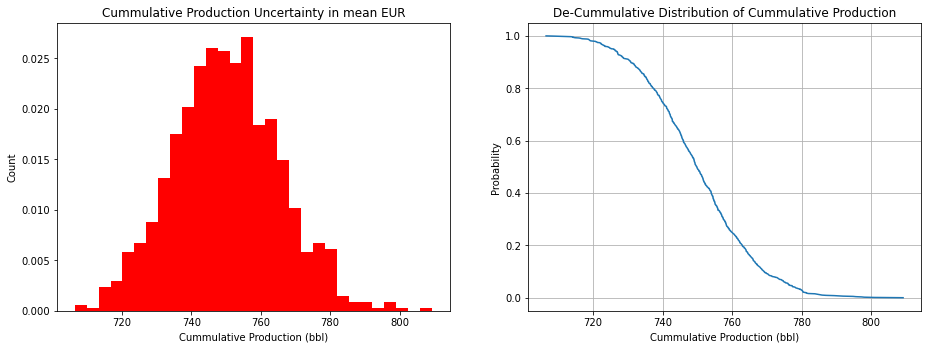

In [4]:
#populate EUR with the estimated Recovery values in any units

EUR = np.linspace(500,1000,100) 
units = 'bbl'
#Bootstrap
n = 0
means = []
while n < 1000:
    n+=1
    samples = []
    for i in range(0,len(EUR)):
        index = np.random.randint(0,len(EUR))
        samples = np.append(samples,EUR[index])
    avg = np.mean(samples)
    means = np.append(means,avg)
    
    

bins = 30
plt.subplot(1,2,1)
n, bins,patches = plt.hist(means,bins,facecolor = 'r',density=True)
plt.xlabel('Cummulative Production '+ '('+ units +')' )
plt.ylabel('Count')
plt.title('Cummulative Production Uncertainty in mean EUR')



prob = np.linspace(0,1.0,len(means))
means_cdf = np.sort(means)
means_cdf = np.flip(means_cdf,0)


plt.subplot(1,2,2)
plt.plot(means_cdf,prob)
plt.ylabel('Probability' )
plt.xlabel('Cummulative Production '+ '('+ units +')' )
plt.title('De-Cummulative Distribution of Cummulative Production')
plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

p10 = np.percentile(means_cdf,10)
p50 = np.percentile(means_cdf,50)
p90 = np.percentile(means_cdf,90)

print('10% chance of having',p90,'or more','', units, '')
print('50% chance of having',p50,'or more','', units, '')
print('90% chance of having',p10,'or more','', units, '')
